In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
from itertools import izip

In [2]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

In [4]:
dt=.2
T=int(7000/dt)#int(3600/dt)

V_PLC=1.2#1.3#.13
K_PLC=.2#0.22
K_5=0.66
K_3=0.4
k_3=0.0

k_1=1.11
k_a=0.08
k_p=0.13
k_2=0.0203
V_SERCA=0.9
K_SERCA=0.1
c_tot=2
beta=.185
tau=12.5
k_i=0.4
tau_p=1

Vpm=0.0
Kpm=0.01#0.15
phi=0#0.0047
v0=0.0008
epsilon=.0
pow_cal=2
j_in=0

v8=.00
kg=0
alpha=0.0

#================================================
tau_new_max=1000
kk_tau_new_vector=[.5,.75,1]
vplc_vector=np.arange(2,5,.025)
#================================================

X=np.zeros((4,T,len(vplc_vector)))
tracker2= np.zeros((1,T))
tracker1= np.zeros((1,T))
tracker3= np.zeros((1,T))
X[0,0,:]=.05
X[1,0,:]=1
X[2,0,:]=(c_tot-.05)/beta
X[3,0,:]=0.5


for j in xrange(len(vplc_vector)):
    for i in xrange(1,T):
        c_old=X[0,i-1,j]
        p_old=X[1,i-1,j]
        s_old=X[2,i-1,j]
        r_old=X[3,i-1,j]
        #kk_tau_new=kk_tau_new_vector[j]
        kk_tau_new=1
        V_PLC= vplc_vector[j]

        c_new=c_old+dt*((k_1*(r_old*c_old*p_old/(k_a+c_old)/(k_p+p_old))**3 +k_2 )*(s_old-c_old) -V_SERCA*c_old**2/(c_old**2+ K_SERCA**2) +epsilon*(v0+phi*V_PLC/(k_3+K_5) -Vpm*c_old**2/(c_old**2+ Kpm**2)) )
        p_new=p_old+dt*tau_p*(V_PLC*c_old**pow_cal/(c_old**pow_cal+ K_PLC**pow_cal)  -  K_5*p_old -k_3*p_old*c_old**2/(c_old**2+ K_3**2)  )
        s_new=s_old+dt*(1.0/beta)*( V_SERCA*c_old**2/(c_old**2+ K_SERCA**2)- (k_1*(r_old*c_old*p_old/(k_a+c_old)/(k_p+p_old))**3 +k_2 )*(s_old-c_old) )
        #r_new=r_old+dt*(1.0/tau)*( 1-r_old*(k_i+X[0,(i-1)])/k_i)#r_profile[i]#
        tau_new= tau_new_max * (kk_tau_new**4)/(c_old**4+ kk_tau_new**4)
        r_new=r_old+dt*(1.0/tau_new)*( 1-r_old*(k_i+c_old)/k_i)#r_profile[i]#

        X[0,i,j]=c_new
        X[1,i,j]=p_new
        X[2,i,j]=s_new
        X[3,i,j]=r_new

In [5]:
freq = np.zeros((len(vplc_vector),1))
for j in xrange(len(vplc_vector)):
    maxtab, mintab = peakdet(X[0,:,j],.05)
    
    if len(maxtab)>1:
        indices=np.sort(maxtab[:,0])
        #print(indices)
        period=(indices[1]-indices[0])*dt
        freq[j,0]=2*np.pi*1000.0/period

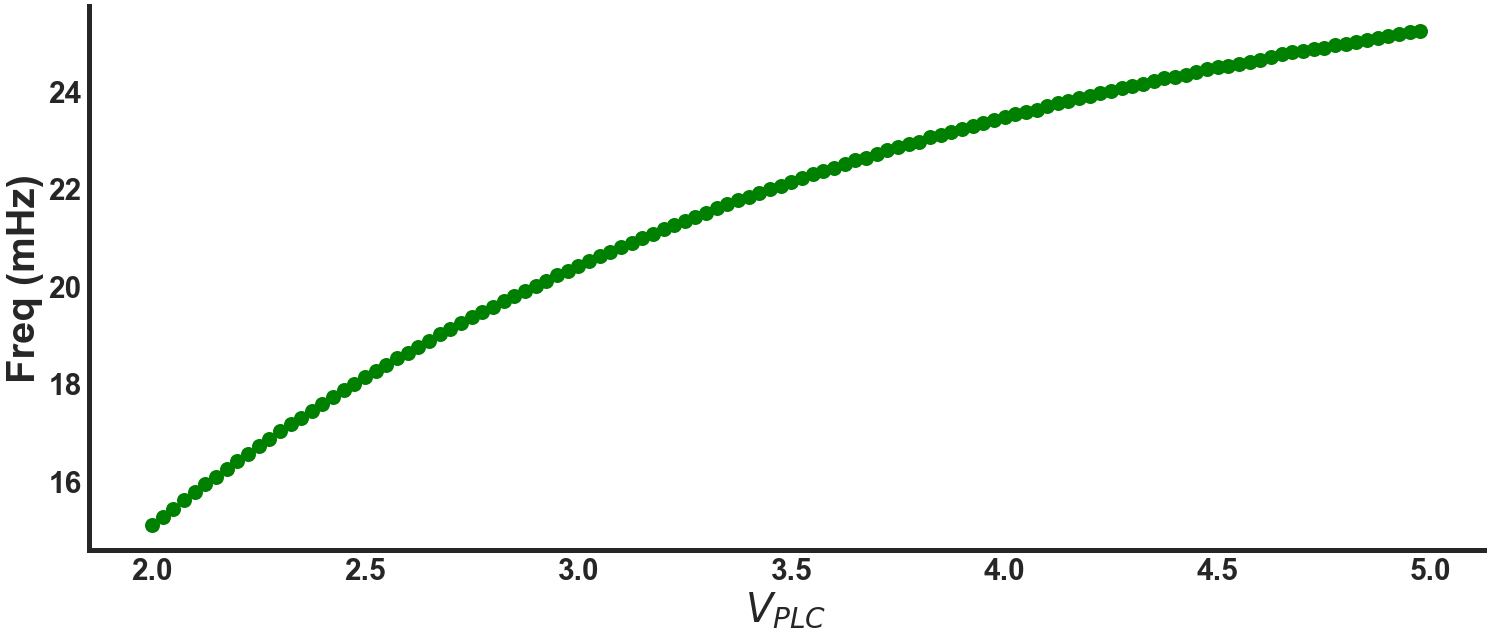

In [6]:
with sns.axes_style("white"):
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30,fontweight='bold')
    plt.xticks(fontsize=30,fontweight='bold')
    plt.plot(vplc_vector,freq ,'go',markersize=15,linewidth=12 )

    
    
    plt.xlabel(r'$V_{PLC}$',fontsize=40,fontweight='bold')
    ax.set_ylabel('Freq (mHz)',fontsize=40,fontweight='bold')
    
#fig.savefig("./figures/modified_Model_Freq_profile.pdf",transparent=True) 

In [7]:
dt=.2
T=int(7000/dt)#int(3600/dt)

V_PLC=1.2#1.3#.13
K_PLC=.2#0.22
K_5=0.66
K_3=0.4
k_3=0.0

k_1=1.11
k_a=0.08
k_p=0.13
k_2=0.0203
V_SERCA=0.9
K_SERCA=0.1
c_tot=2
beta=.185
tau=12.5
k_i=0.4
tau_p=1

Vpm=0.0
Kpm=0.01#0.15
phi=0#0.0047
v0=0.0008
epsilon=.0
pow_cal=2
j_in=0

v8=.00
kg=0
alpha=0.0

#================================================
tau_new_max=800
kk_tau_new_vector=np.arange(0.5,2.5,.025)#[0.5,1,1.5]#
tau_new_max_profile=np.linspace(1000,830,len(kk_tau_new_vector))#[1000,875,830]#
#================================================

X=np.zeros((4,T,len(kk_tau_new_vector)))
tracker2= np.zeros((1,T))
tracker1= np.zeros((1,T))
tracker3= np.zeros((1,T))
X[0,0,:]=.05
X[1,0,:]=1
X[2,0,:]=(c_tot-.05)/beta
X[3,0,:]=0.5


for j in xrange(len(kk_tau_new_vector)):
    for i in xrange(1,T):
        c_old=X[0,i-1,j]
        p_old=X[1,i-1,j]
        s_old=X[2,i-1,j]
        r_old=X[3,i-1,j]
        kk_tau_new=kk_tau_new_vector[j]
        tau_new_max= tau_new_max_profile[j]

        c_new=c_old+dt*((k_1*(r_old*c_old*p_old/(k_a+c_old)/(k_p+p_old))**3 +k_2 )*(s_old-c_old) -V_SERCA*c_old**2/(c_old**2+ K_SERCA**2) +epsilon*(v0+phi*V_PLC/(k_3+K_5) -Vpm*c_old**2/(c_old**2+ Kpm**2)) )
        p_new=p_old+dt*tau_p*(V_PLC*c_old**pow_cal/(c_old**pow_cal+ K_PLC**pow_cal)  -  K_5*p_old -k_3*p_old*c_old**2/(c_old**2+ K_3**2)  )
        s_new=s_old+dt*(1.0/beta)*( V_SERCA*c_old**2/(c_old**2+ K_SERCA**2)- (k_1*(r_old*c_old*p_old/(k_a+c_old)/(k_p+p_old))**3 +k_2 )*(s_old-c_old) )
        #r_new=r_old+dt*(1.0/tau)*( 1-r_old*(k_i+X[0,(i-1)])/k_i)#r_profile[i]#
        tau_new= tau_new_max * (kk_tau_new**4)/(c_old**4+ kk_tau_new**4)
        r_new=r_old+dt*(1.0/tau_new)*( 1-r_old*(k_i+c_old)/k_i)#r_profile[i]#

        X[0,i,j]=c_new
        X[1,i,j]=p_new
        X[2,i,j]=s_new
        X[3,i,j]=r_new

In [8]:
whm = np.zeros((len(kk_tau_new_vector),1))
for j in xrange(len(kk_tau_new_vector)):
    maxtab, mintab = peakdet(X[0,:,j],.05)
    
    if len(maxtab)>1:
        deducted= X[0,:,j]-(X[0,:,j].max()/2.0)
        #indices=np.sort(maxtab[:,0])
        zero_crossings = np.where(np.diff(np.sign(deducted)))[0]
        #print(zero_crossings[3]-zero_crossings[2])
        #period=(indices[1]-indices[0])*dt
        whm[j,0]=(zero_crossings[3]-zero_crossings[2])*dt

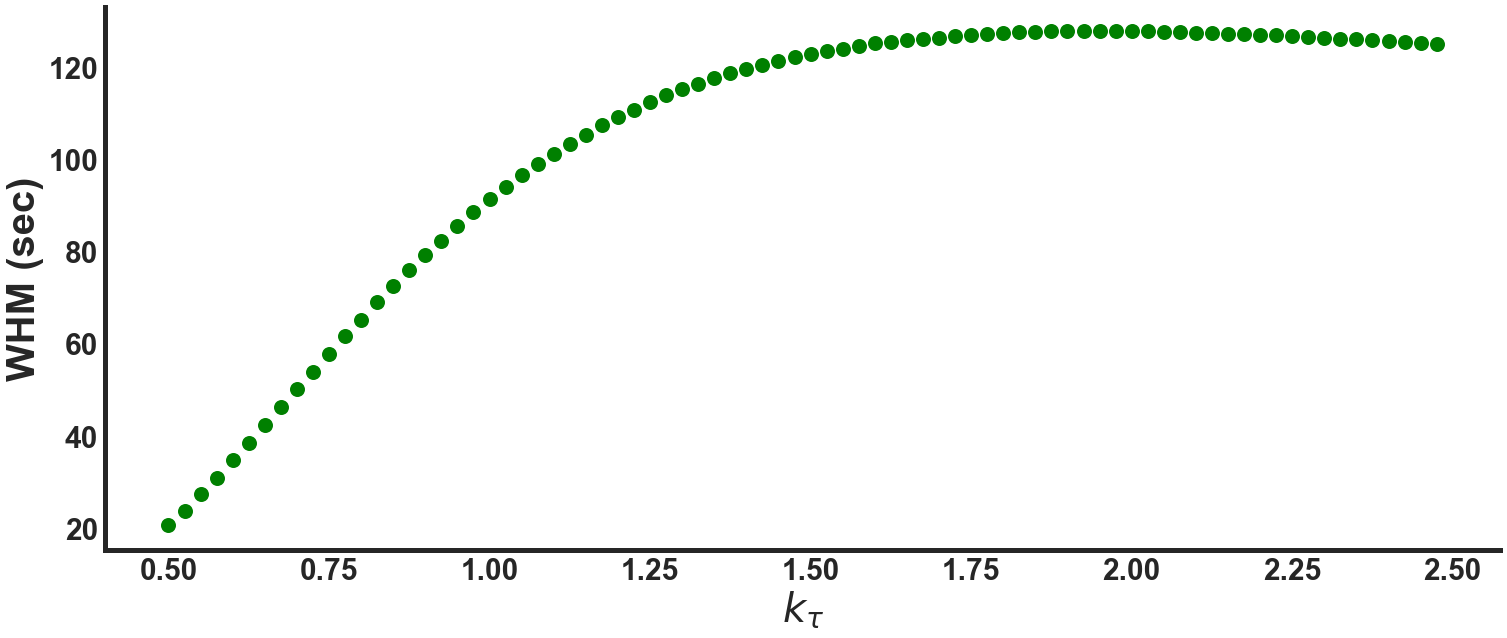

In [9]:
with sns.axes_style("white"):
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30,fontweight='bold')
    plt.xticks(fontsize=30,fontweight='bold')
    plt.plot(kk_tau_new_vector,whm ,'go',markersize=15,linewidth=12 )

    
    
    plt.xlabel(r'$k_{\tau}$',fontsize=40,fontweight='bold')
    ax.set_ylabel('WHM (sec)',fontsize=40,fontweight='bold')
    
#fig.savefig("./figures/modified_Model_WHM_profile.pdf",transparent=True) 